# ISING Model with Transient Field

### VQA and system evolution with Trotterization of the temporal evolution

In [1]:
# -------------------------------------------------------
# LIBRERÍAS NECESARIAS
# -------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, SparsePauliOp, state_fidelity
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import EfficientSU2
from qiskit_aer import AerSimulator
from qiskit.primitives import StatevectorEstimator as Estimator

# -------------------------------------------------------
# 1. HAMILTONIANO (Modelo de Ising con campo transversal)
# -------------------------------------------------------
# Se define el Hamiltoniano del modelo de Ising en 1D con dos qubits:
#   H = -J * Z0 Z1 - g * X0 - g * X1
# Esto representa una interacción entre espines (ZZ) y un campo transversal (X)

J = 1.0   # Constante de acoplamiento entre qubits (interacción ZZ)
g = 0.5   # Intensidad del campo transversal (X)

hamiltonian = SparsePauliOp.from_list([
    ("ZZ", -J),
    ("XI", -g),  # X en el qubit 0
    ("IX", -g)   # X en el qubit 1
])

# -------------------------------------------------------
# 2. ANSATZ Y DEFINICIÓN DEL CIRCUITO PARAMETRIZADO
# -------------------------------------------------------
# Se usa el ansatz EfficientSU2 como aproximación del estado fundamental
# con puertas RX y RY, una capa de repetición y entrelazamiento completo

n_qubits = 2
n_layers = 1
ansatz = EfficientSU2(n_qubits, su2_gates=["rx", "ry"], reps=n_layers, entanglement="full")

params = ParameterVector("theta", ansatz.num_parameters)  # Vector de parámetros libres

# Estimador para obtener el valor esperado del Hamiltoniano
estimator = Estimator()

# -------------------------------------------------------
# 3. OPTIMIZACIÓN VQA PARA ENCONTRAR EL ESTADO FUNDAMENTAL
# -------------------------------------------------------

# Función de costo: energía esperada del Hamiltoniano con el ansatz parametrizado
cost_hist = []
def cost_func_vqa(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs  # Valor esperado de la energía
    cost_hist.append(cost)
    return cost

# Punto inicial para la optimización
x0 = np.ones(ansatz.num_parameters)

# Algoritmo de optimización clásica COBYLA
res = minimize(cost_func_vqa, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA")

# Energía estimada mínima encontrada (estado fundamental)
energia_minima = res.fun
print("Energía estimada del estado fundamental (VQA):", energia_minima)

# Reconstrucción del estado cuántico estimado como estado fundamental
opt_params = res.x
vqa_circuit = ansatz.assign_parameters(opt_params)
vqa_state = Statevector.from_instruction(vqa_circuit)

# -------------------------------------------------------
# 4. EVOLUCIÓN TEMPORAL DEL SISTEMA DESDE |00⟩
# -------------------------------------------------------
# Se simula la evolución del sistema bajo el Hamiltoniano usando trotterización
# La evolución es aproximada en pequeños pasos de tiempo (Trotter-Suzuki)

n_steps = 30          # Número de pasos de Trotter
max_time = 50         # Tiempo máximo de evolución
time_points = np.linspace(0, max_time, 200)  # Puntos de tiempo a evaluar

# Simulador cuántico de Aer
sim = AerSimulator()

# Variables para almacenar probabilidades de cada estado y fidelidad
probs_00, probs_01, probs_10, probs_11 = [], [], [], []
fidelidades = []

for t in time_points:
    dt = t / n_steps  # Paso de tiempo para trotterización
    qc = QuantumCircuit(2)

    # Trotterización de la evolución temporal e^{-iHt}
    for _ in range(n_steps):
        qc.cx(0, 1)
        qc.rz(-2 * J * dt, 1)
        qc.cx(0, 1)
        qc.rx(-2 * g * dt, 0)
        qc.rx(-2 * g * dt, 1)

    # Guardamos el estado resultante
    qc.save_statevector()
    compiled = transpile(qc, sim)
    result = sim.run(compiled).result()
    evolved_state = Statevector(result.get_statevector())

    # Probabilidades de cada estado base
    state_probs = evolved_state.probabilities_dict()
    probs_00.append(state_probs.get("00", 0))
    probs_01.append(state_probs.get("01", 0))
    probs_10.append(state_probs.get("10", 0))
    probs_11.append(state_probs.get("11", 0))

    # Calculamos fidelidad entre el estado evolutivo y el estimado por VQA
    fidelidades.append(state_fidelity(evolved_state, vqa_state))


C:\Users\jgcg3\AppData\Local\Temp\ipykernel_25396\2877109100.py:39: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  ansatz = EfficientSU2(n_qubits, su2_gates=["rx", "ry"], reps=n_layers, entanglement="full")


Energía estimada del estado fundamental (VQA): -1.4142135580044068


### Results

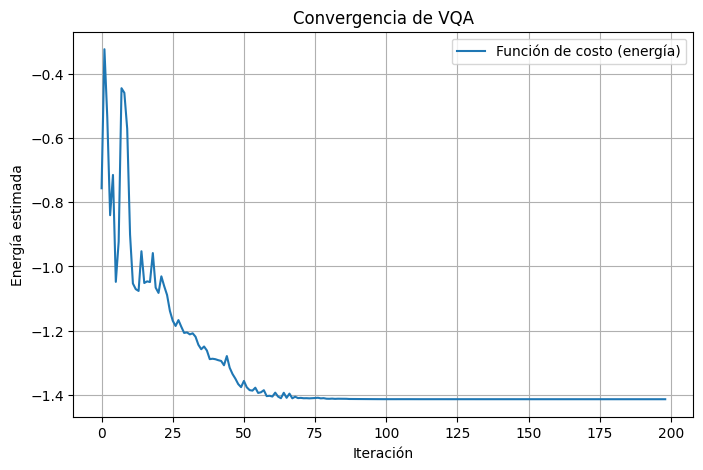

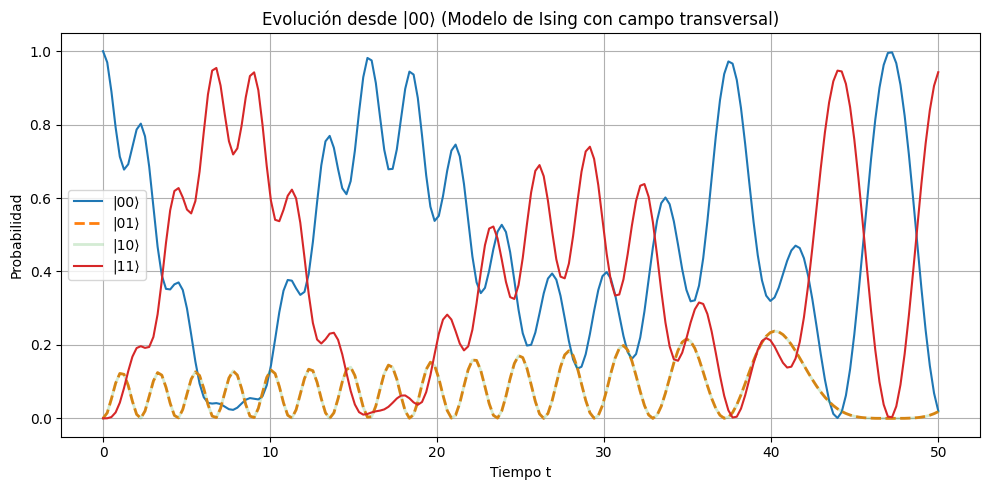

In [26]:
# -------------------------------------------------------
# 5. VISUALIZACIÓN DE RESULTADOS
# -------------------------------------------------------

# ---------------------------
# 5.1 Convergencia del VQA
# ---------------------------
# Este gráfico muestra cómo evoluciona la función de costo (energía estimada) a lo largo de las iteraciones del optimizador clásico.
# Se espera que esta curva baje progresivamente hasta estabilizarse, indicando que el VQA ha encontrado una buena aproximación del estado fundamental.

plt.figure(figsize=(8, 5))
plt.plot(cost_hist, label="Función de costo (energía)")
plt.xlabel("Iteración")
plt.ylabel("Energía estimada")
plt.title("Convergencia de VQA")
plt.grid(True)
plt.legend()
plt.show()

# ---------------------------
# 5.2 Evolución temporal del sistema desde |00⟩
# ---------------------------
# Aquí se muestra cómo cambian las probabilidades de observar cada estado base (|00⟩, |01⟩, |10⟩, |11⟩) durante la evolución temporal del sistema.
# Esta dinámica cuántica está gobernada por el Hamiltoniano del modelo de Ising.
# Es útil para observar fenómenos de oscilación de población entre estados (como oscilaciones de Rabi, interferencia cuántica, etc.)

plt.figure(figsize=(10, 5))
plt.plot(time_points, probs_00, label='|00⟩')
plt.plot(time_points, probs_01, label='|01⟩', lw=2, ls='--')
plt.plot(time_points, probs_10, label='|10⟩', lw=2, alpha=0.2)
plt.plot(time_points, probs_11, label='|11⟩')
plt.xlabel("Tiempo t")
plt.ylabel("Probabilidad")
plt.title("Evolución desde |00⟩ (Modelo de Ising con campo transversal)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Quantum Error Mitigation and Simulation with and without noise

C:\Users\jgcg3\AppData\Local\Temp\ipykernel_25396\1922457368.py:41: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  ansatz   = EfficientSU2(n_qubits, su2_gates=["rx","ry"],


Energía estimada (VQA ideal): -1.4142135580044068


C:\Users\jgcg3\anaconda3\envs\quantumComputing\Lib\site-packages\mthree\mitigation.py:588: UserWarning: No calibration data. Calibrating: [0, 1]
  warnings.warn("No calibration data. Calibrating: {}".format(qubits))


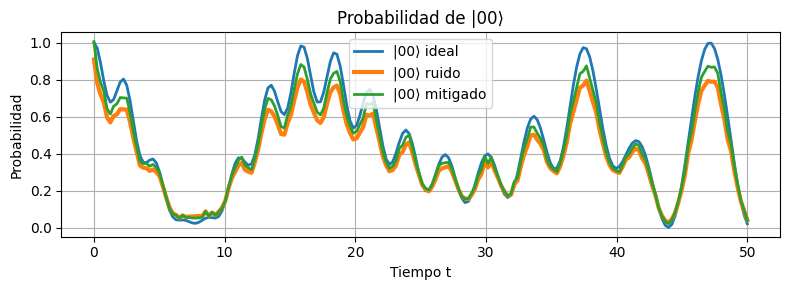

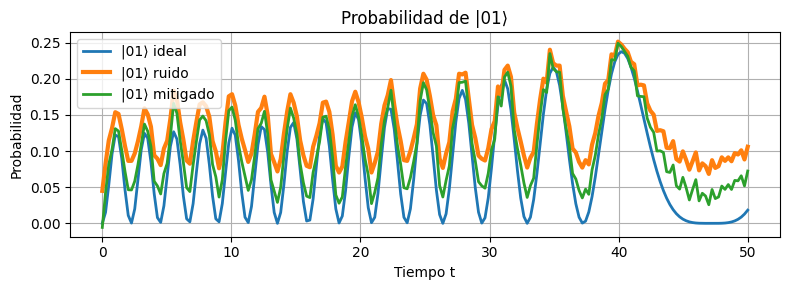

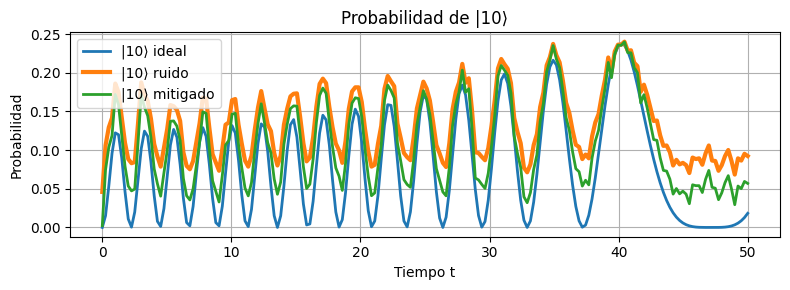

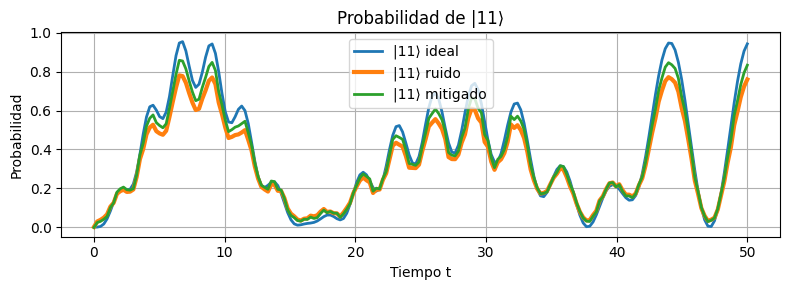

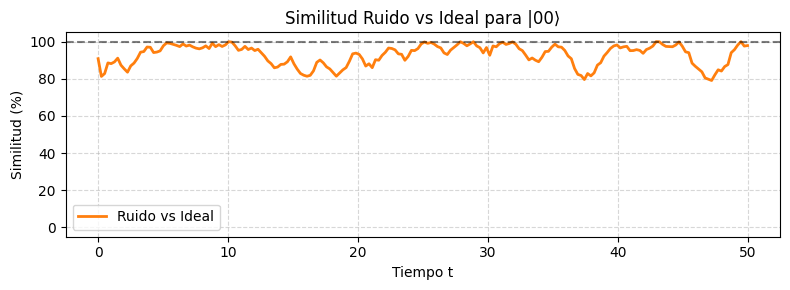

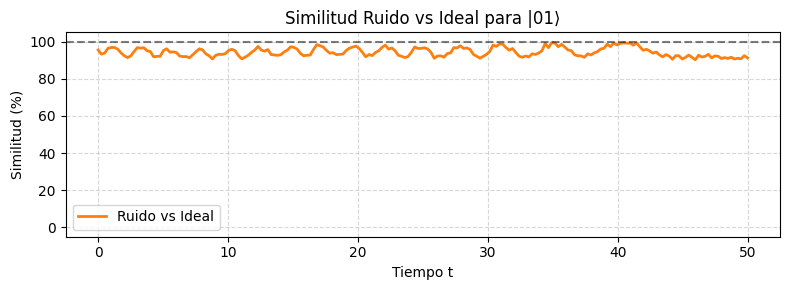

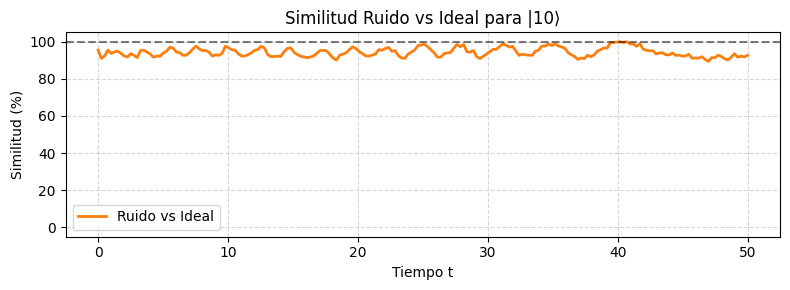

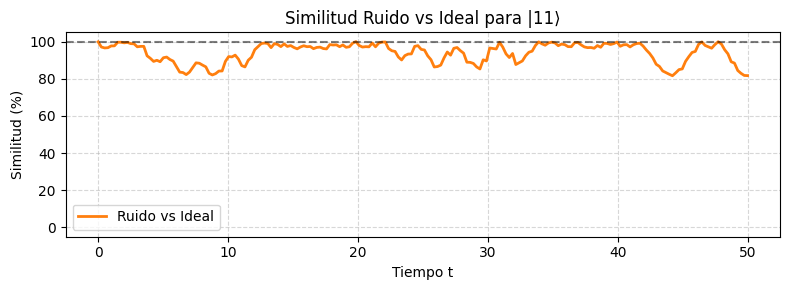

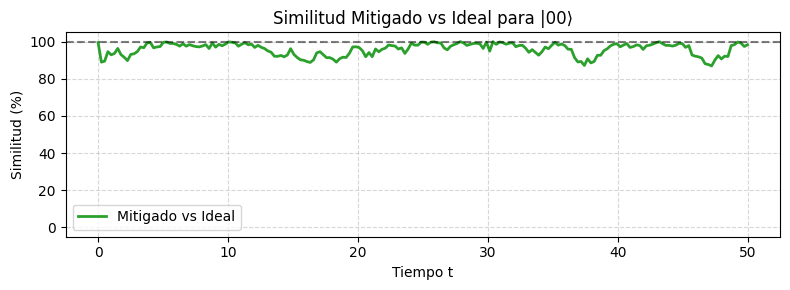

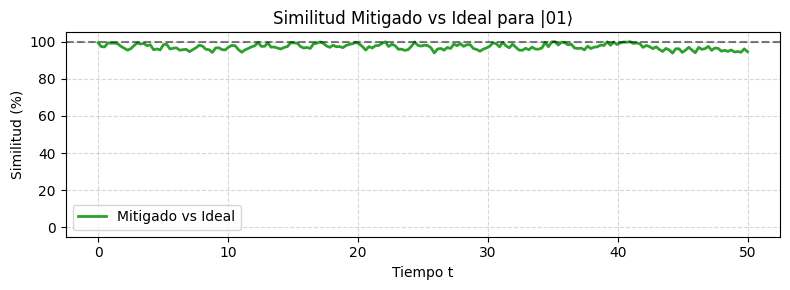

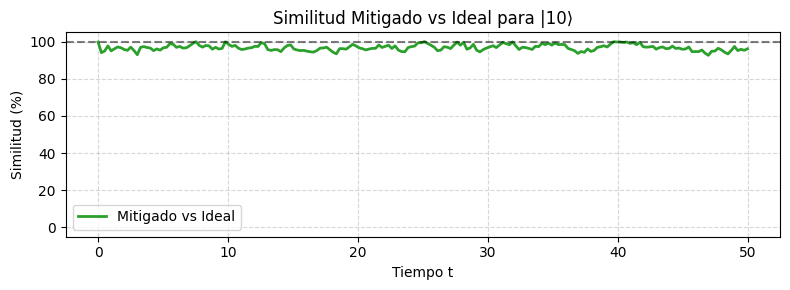

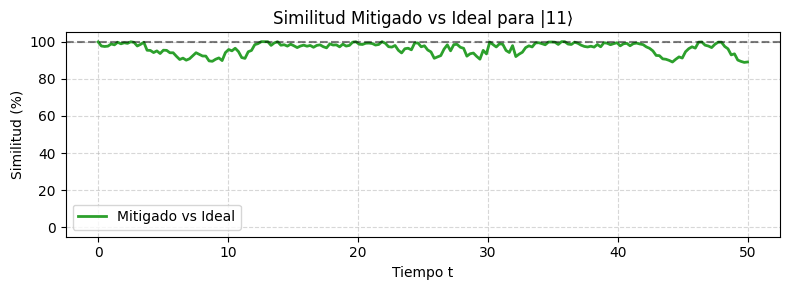

In [16]:
# -------------------------------------------------------
# LIBRERÍAS NECESARIAS
# -------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, SparsePauliOp, state_fidelity
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import EfficientSU2
from qiskit_aer import AerSimulator
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.result import Counts  # Para procesar resultados de medición

# Para ruido, mitigación M3 y ZNE
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
import mthree
import mitiq
from mitiq.zne.scaling import fold_global
from mitiq.zne.inference import RichardsonFactory

# -------------------------------------------------------
# 1. DEFINICIÓN DEL HAMILTONIANO (Ising con campo transversal)
# -------------------------------------------------------
J = 1.0
g = 0.5
hamiltonian = SparsePauliOp.from_list([
    ("ZZ", -J),
    ("XI", -g),
    ("IX", -g)
])
# Energía exacta conocida para comparar
exact_ground_state_energy = -np.sqrt(2)

# -------------------------------------------------------
# 2. ANSATZ PARAMETRIZADO PARA VQE
# -------------------------------------------------------
n_qubits = 2
n_layers = 1
ansatz   = EfficientSU2(n_qubits, su2_gates=["rx","ry"],
                        reps=n_layers, entanglement="full")
params   = ParameterVector("theta", ansatz.num_parameters)
estimator = Estimator()

# -------------------------------------------------------
# 3. FUNCIÓN DE COSTO VQA IDEAL (sin ruido)
# -------------------------------------------------------
cost_hist = []
def cost_func_vqa(x):
    # Ejecuta el estimador de vectores de estado para obtener la energía
    ev = estimator.run([(ansatz, hamiltonian, x)]).result()[0].data.evs
    cost_hist.append(ev)
    return ev

# Optimización COBYLA
x0 = np.ones(ansatz.num_parameters)
res = minimize(cost_func_vqa, x0, method="COBYLA")
vqa_state = Statevector.from_instruction(ansatz.assign_parameters(res.x))
print("Energía estimada (VQA ideal):", res.fun)

# -------------------------------------------------------
# 4. CONFIGURACIÓN DEL MODELO DE RUIDO, MITIGACIÓN M3 Y ZNE
# -------------------------------------------------------
# Parámetros de error de puertas
p1, p2     = 0.01, 0.03
T1, T2, dt = 80e3, 60e3, 0.222e-6
depol1 = depolarizing_error(p1, 1)
therm1 = thermal_relaxation_error(T1, T2, dt)
err1q  = depol1.compose(therm1)
depol2 = depolarizing_error(p2, 2)

# Error de lectura (readout) del 5%
ro_error = ReadoutError([[0.95, 0.05],
                         [0.05, 0.95]])

# Construcción del noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(err1q, ['rx','ry','rz'])
noise_model.add_all_qubit_quantum_error(depol2, ['cx'])
noise_model.add_all_qubit_readout_error(ro_error)

# Instancias de simulador
sim_ideal = AerSimulator(method="statevector")
sim_noisy = AerSimulator(noise_model=noise_model, method="density_matrix")

# Mitigador de read-out M3
mitigator = mthree.M3Mitigation(sim_noisy)

# Configuración de ZNE (Zero-Noise Extrapolation)
factory = RichardsonFactory([1, 3, 5])
def exec_counts(circ):
    transp_c = transpile(circ, sim_noisy)
    return sim_noisy.run(transp_c, shots=2048).result().get_counts()

# -------------------------------------------------------
# 5. EVOLUCIÓN TEMPORAL + RECOLECCIÓN DE PROBABILIDADES Y FIDELIDADES
# -------------------------------------------------------
n_steps     = 30
max_time    = 50
time_points = np.linspace(0, max_time, 200)

# Diccionarios para guardar resultados
probs_id = {bs: [] for bs in ['00','01','10','11']}
probs_nz = {bs: [] for bs in ['00','01','10','11']}
probs_m3 = {bs: [] for bs in ['00','01','10','11']}
fid_id, fid_nz, fid_m3 = [], [], []

for t in time_points:
    dt = t / n_steps

    # Construcción del circuito trotterizado
    qc = QuantumCircuit(2)
    for _ in range(n_steps):
        qc.cx(0,1); qc.rz(-2*J*dt,1); qc.cx(0,1)
        qc.rx(-2*g*dt,0); qc.rx(-2*g*dt,1)

    # 5.1) IDEAL
    qci = qc.copy()
    qci.save_statevector()
    sv = sim_ideal.run(transpile(qci, sim_ideal)).result().get_statevector()
    psi = Statevector(sv)
    fid_id.append(state_fidelity(psi, vqa_state))
    p_id = psi.probabilities_dict()
    for bs in probs_id:
        probs_id[bs].append(p_id.get(bs,0))

    # 5.2) RUIDO SIN MITIGAR
    qcn = qc.copy()
    qcn.measure_all()
    res_n = sim_noisy.run(transpile(qcn, sim_noisy), shots=2048).result()
    counts = res_n.get_counts()
    total  = sum(counts.values())
    p_nz   = {bs: counts.get(bs,0)/total for bs in probs_nz}
    for bs in probs_nz:
        probs_nz[bs].append(p_nz[bs])
    fid_nz.append(sum(p_nz[bs]*abs(vqa_state[int(bs,2)])**2 for bs in probs_nz))

    # 5.3) RUIDO + M3 (corrige read-out)
    counts_corr = mitigator.apply_correction(counts, qubits=[0,1])
    total_c     = sum(counts_corr.values())
    p_m3d       = {bs: counts_corr.get(bs,0)/total_c for bs in probs_m3}
    for bs in probs_m3:
        probs_m3[bs].append(p_m3d[bs])
    fid_m3.append(sum(p_m3d[bs]*abs(vqa_state[int(bs,2)])**2 for bs in probs_m3))

# -------------------------------------------------------
# 6. GRAFICAR PROBABILIDADES POR ESTADO (vertical apilado)
# -------------------------------------------------------
states = ['00','01','10','11']
titles = ['|00⟩','|01⟩','|10⟩','|11⟩']

for bs, title in zip(states, titles):
    plt.figure(figsize=(8,3))
    plt.plot(time_points, probs_id[bs],
             label=f"{title} ideal",   color="tab:blue", lw=2)
    plt.plot(time_points, probs_nz[bs],
             label=f"{title} ruido",   color="tab:orange", lw=3)
    plt.plot(time_points, probs_m3[bs],
             label=f"{title} mitigado",color="tab:green",  lw=2)
    plt.xlabel("Tiempo t")
    plt.ylabel("Probabilidad")
    plt.title(f"Probabilidad de {title}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------
# 7. SIMILITUD INSTANTÁNEA (%) VS IDEAL
# -------------------------------------------------------
states = ['00','01','10','11']
titles = ['|00⟩','|01⟩','|10⟩','|11⟩']

# 7.1) Ruido vs Ideal
for bs, title in zip(states, titles):
    p_id = np.array(probs_id[bs])
    p_nz = np.array(probs_nz[bs])
    sim_nz = 100 * (1 - np.abs(p_id - p_nz))
    sim_nz = np.clip(sim_nz, 0, 100)

    plt.figure(figsize=(8,3))
    plt.plot(time_points, sim_nz,
             color="tab:orange", lw=2,
             label="Ruido vs Ideal")
    plt.axhline(100, color='k', ls='--', alpha=0.5)
    plt.ylim(-5,105)
    plt.xlabel("Tiempo t")
    plt.ylabel("Similitud (%)")
    plt.title(f"Similitud Ruido vs Ideal para {title}")
    plt.grid(True, ls='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 7.2) Mitigado vs Ideal
for bs, title in zip(states, titles):
    p_id = np.array(probs_id[bs])
    p_m3 = np.array(probs_m3[bs])
    sim_m3 = 100 * (1 - np.abs(p_id - p_m3))
    sim_m3 = np.clip(sim_m3, 0, 100)

    plt.figure(figsize=(8,3))
    plt.plot(time_points, sim_m3,
             color="tab:green", lw=2,
             label="Mitigado vs Ideal")
    plt.axhline(100, color='k', ls='--', alpha=0.5)
    plt.ylim(-5,105)
    plt.xlabel("Tiempo t")
    plt.ylabel("Similitud (%)")
    plt.title(f"Similitud Mitigado vs Ideal para {title}")
    plt.grid(True, ls='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


### Results:

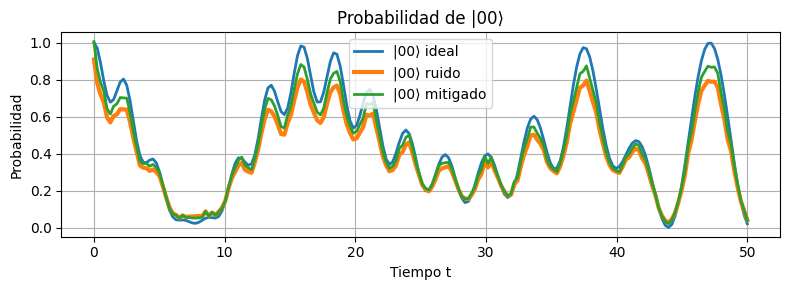

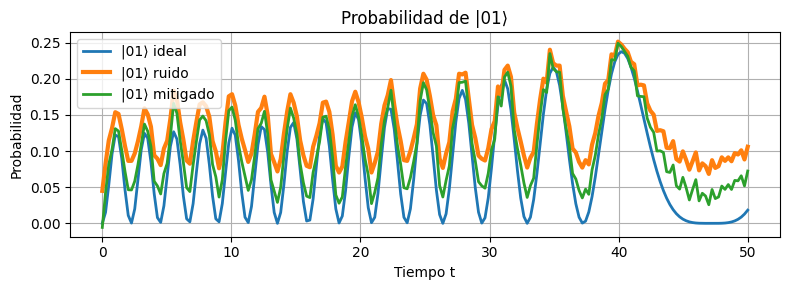

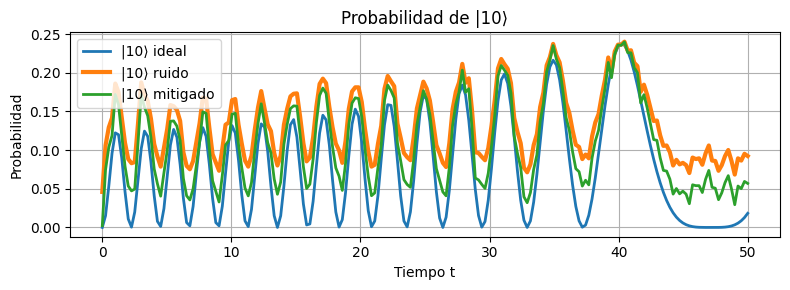

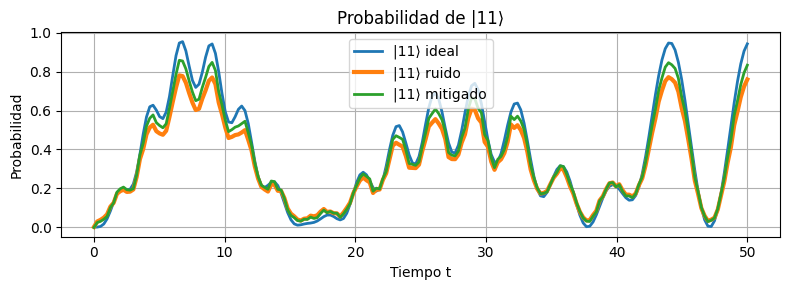

In [17]:
# -------------------------------------------------------
# GRAFICAS
# -------------------------------------------------------
# Definimos los estados y sus etiquetas para graficar
states = ['00','01','10','11']
titles = ['|00⟩','|01⟩','|10⟩','|11⟩']

# Recorremos cada estado y dibujamos su probabilidad ideal, con ruido y mitigada
for bs, title in zip(states, titles):
    plt.figure(figsize=(8,3))
    # Curva ideal sin ruido
    plt.plot(time_points, probs_id[bs],
             label=f"{title} ideal",   color="tab:blue",   lw=2)
    # Curva con ruido sin mitigación
    plt.plot(time_points, probs_nz[bs],
             label=f"{title} ruido",   color="tab:orange", lw=3)
    # Curva con ruido y aplicación de mitigación M3
    plt.plot(time_points, probs_m3[bs],
             label=f"{title} mitigado",color="tab:green",  lw=2)
    
    plt.xlabel("Tiempo t"); plt.ylabel("Probabilidad")
    plt.title(f"Probabilidad de {title}")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()



--- Plotting VQE Convergence Comparison ---
Theoretical Exact Ground State Energy: -1.414214
VQE Noiseless Energy (Min):          -1.414214
VQE Noisy Energy (Min):              -1.324219
Difference (Noiseless vs. Noisy):    0.089995


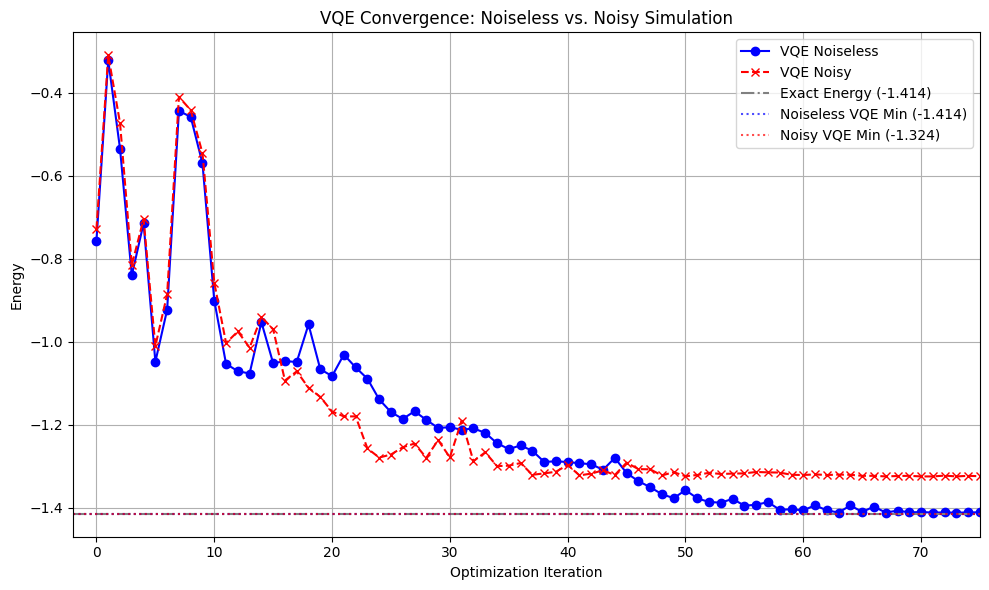

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# --- VARIABLES ASUMIDAS DE VQE ANTERIOR ---
# Sustituye estos valores de ejemplo con tus listas reales obtenidas al ejecutar VQE.
if 'noiseless_cost_hist' not in locals():
    noiseless_cost_hist = [-1.0, -1.2, -1.35, -1.41, -1.414] 
    noisy_cost_hist = [-0.8, -0.9, -1.05, -1.15, -1.2]
    energia_minima = -1.414214
    energia_minima_noisy = -1.2
    exact_ground_state_energy = -np.sqrt(2) # -1.41421356...

# --- COMPARACIÓN Y VISUALIZACIÓN DE LA CONVERGENCIA VQE ---
print("\n--- Plotting VQE Convergence Comparison ---")
print(f"Theoretical Exact Ground State Energy: {exact_ground_state_energy:.6f}")
print(f"VQE Noiseless Energy (Min):          {energia_minima:.6f}")
print(f"VQE Noisy Energy (Min):              {energia_minima_noisy:.6f}")
print(f"Difference (Noiseless vs. Noisy):    {abs(energia_minima - energia_minima_noisy):.6f}")

plt.figure(figsize=(10, 6))
# 1) Convergencia ideal (sin ruido)
plt.plot(cost_hist, label='VQE Noiseless', marker='o', linestyle='-', color='blue')
plt.xlim(-2, 75)

# 2) Convergencia con ruido
plt.plot(noisy_cost_hist, label='VQE Noisy', marker='x', linestyle='--', color='red')

# 3) Línea de energía exacta
plt.axhline(y=exact_ground_state_energy, color='gray', linestyle='-.', label=f'Exact Energy ({exact_ground_state_energy:.3f})')

# 4) Líneas marcando los mínimos finales
plt.axhline(y=energia_minima, color='blue', linestyle=':', alpha=0.7, label=f'Noiseless VQE Min ({energia_minima:.3f})')
plt.axhline(y=energia_minima, color='red', linestyle=':', alpha=0.7, label=f'Noisy VQE Min ({energia_minima_noisy:.3f})')

# Etiquetas y leyenda
plt.title('VQE Convergence: Noiseless vs. Noisy Simulation')
plt.xlabel('Optimization Iteration')
plt.ylabel('Energy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Results Analysis

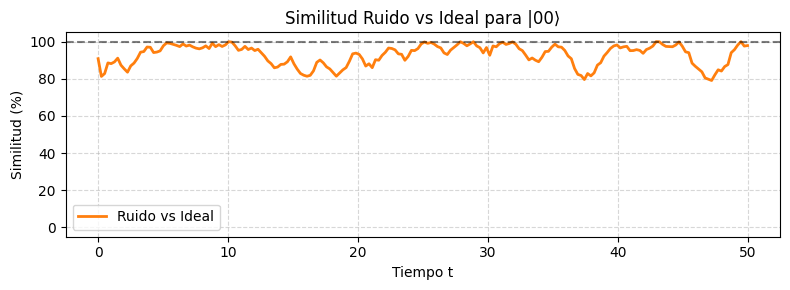

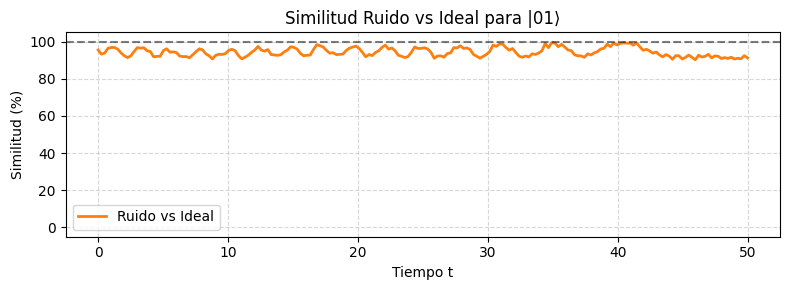

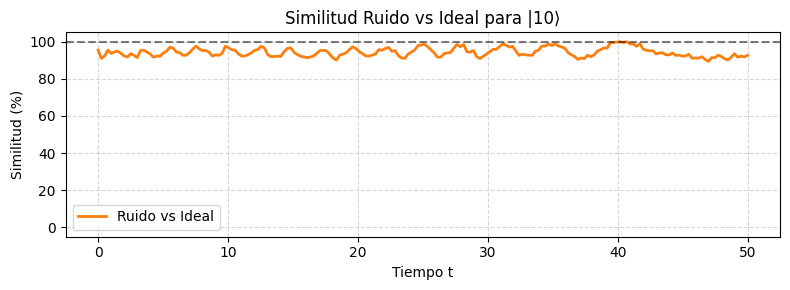

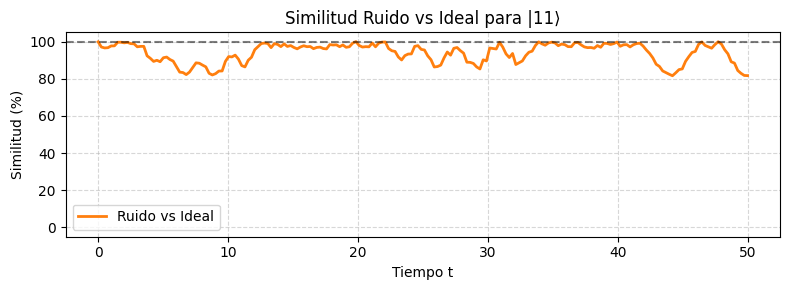

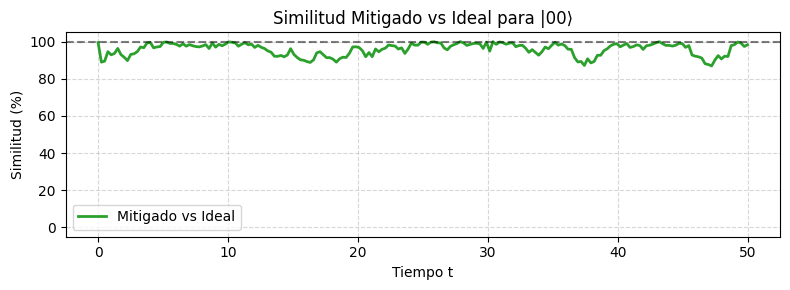

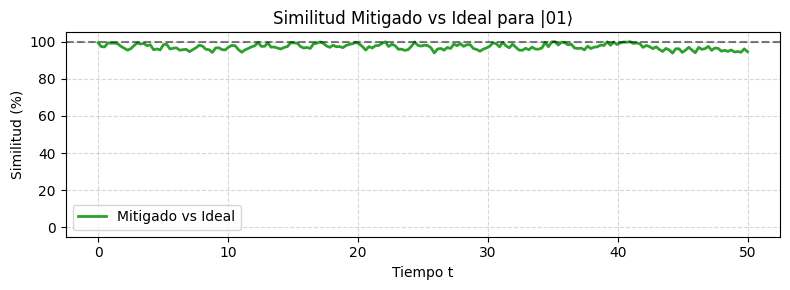

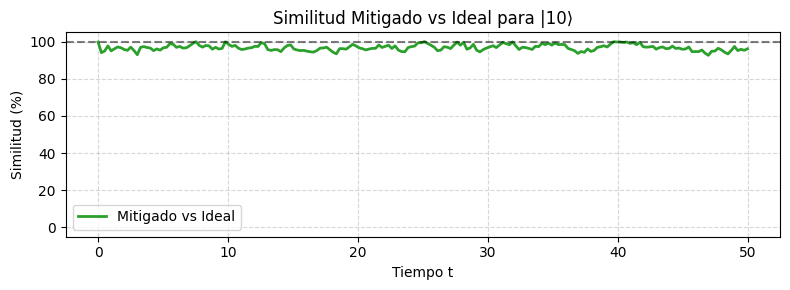

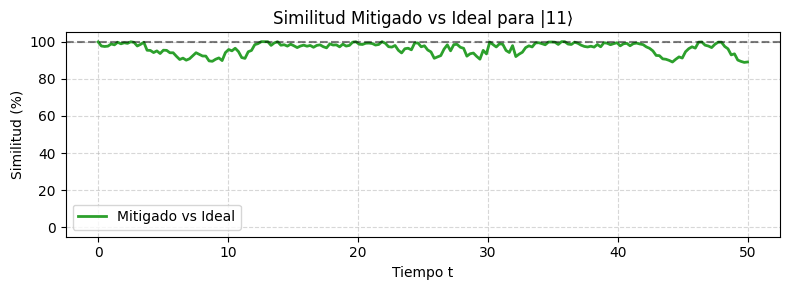

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Definimos los estados base y sus etiquetas para graficar
states = ['00', '01', '10', '11']
titles = ['|00⟩', '|01⟩', '|10⟩', '|11⟩']

# -------------------------------------------------------
# 1) Graficar similitud Ruido vs Ideal para cada estado
# -------------------------------------------------------
for bs, title in zip(states, titles):
    # Convertimos las listas de probabilidades a arrays NumPy
    p_id = np.array(probs_id[bs])    # Probabilidad ideal
    p_nz = np.array(probs_nz[bs])    # Probabilidad con ruido sin mitigar

    # Calculamos similitud instantánea en porcentaje:
    # sim = 100 * (1 - |ideal - ruido|)
    sim_nz = 100 * (1 - np.abs(p_id - p_nz))
    # Nos aseguramos de que la similitud quede entre 0% y 100%
    sim_nz = np.clip(sim_nz, 0, 100)

    # Creamos la figura
    plt.figure(figsize=(8, 3))
    # Dibujamos la curva de similitud
    plt.plot(time_points, sim_nz,
             color="tab:orange", linewidth=2,
             label="Ruido vs Ideal")
    # Línea de referencia al 100%
    plt.axhline(100, color='k', linestyle='--', alpha=0.5)
    # Ajuste de ejes
    plt.ylim(-5, 105)
    plt.xlabel("Tiempo t")
    plt.ylabel("Similitud (%)")
    plt.title(f"Similitud Ruido vs Ideal para {title}")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------
# 2) Graficar similitud Mitigado vs Ideal para cada estado
# -------------------------------------------------------
for bs, title in zip(states, titles):
    # Convertimos las listas de probabilidades a arrays NumPy
    p_id = np.array(probs_id[bs])    # Probabilidad ideal
    p_m3 = np.array(probs_m3[bs])    # Probabilidad mitigada con M3

    # Calculamos similitud instantánea en porcentaje:
    # sim = 100 * (1 - |ideal - mitigado|)
    sim_m3 = 100 * (1 - np.abs(p_id - p_m3))
    # Nos aseguramos de que la similitud quede entre 0% y 100%
    sim_m3 = np.clip(sim_m3, 0, 100)

    # Creamos la figura
    plt.figure(figsize=(8, 3))
    # Dibujamos la curva de similitud
    plt.plot(time_points, sim_m3,
             color="tab:green", linewidth=2,
             label="Mitigado vs Ideal")
    # Línea de referencia al 100%
    plt.axhline(100, color='k', linestyle='--', alpha=0.5)
    # Ajuste de ejes
    plt.ylim(-5, 105)
    plt.xlabel("Tiempo t")
    plt.ylabel("Similitud (%)")
    plt.title(f"Similitud Mitigado vs Ideal para {title}")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


Promedio de similitud a lo largo de toda la evolución (0–100%):
  Estado |00⟩: Ruido vs Ideal = 92.86%   |   Mitigado vs Ideal = 95.91%
  Estado |01⟩: Ruido vs Ideal = 94.38%   |   Mitigado vs Ideal = 97.17%
  Estado |10⟩: Ruido vs Ideal = 94.30%   |   Mitigado vs Ideal = 96.79%
  Estado |11⟩: Ruido vs Ideal = 93.92%   |   Mitigado vs Ideal = 96.36%


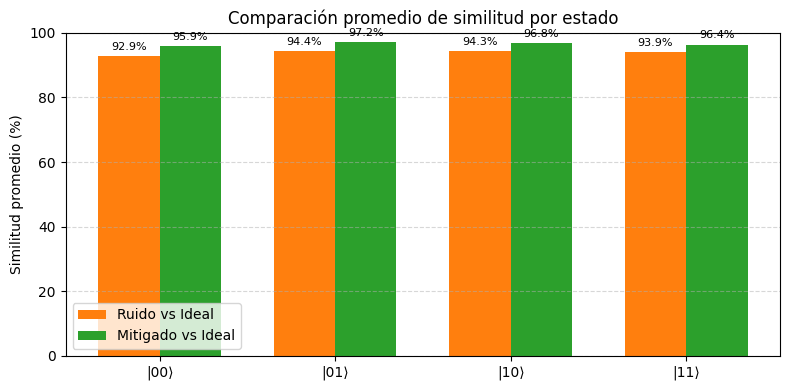

In [24]:
# -------------------------------------------------------
# PROMEDIO DE SIMILITUD GLOBAL POR ESTADO
# -------------------------------------------------------

# Diccionarios para almacenar el promedio de similitud
promedios_nz = {}  # Ruido vs ideal
promedios_m3 = {}  # Mitigado vs ideal

# Calculamos el promedio de similitud en todo el intervalo de tiempo
for bs in states:
    # Convertimos las probabilidades a arrays de NumPy
    p_id = np.array(probs_id[bs])   # Probabilidad ideal
    p_nz = np.array(probs_nz[bs])   # Probabilidad con ruido
    p_m3 = np.array(probs_m3[bs])   # Probabilidad mitigada

    # Similitud instantánea: 100 * (1 - |ideal - otro|)
    sim_nz = 100 * (1 - np.abs(p_id - p_nz))
    sim_m3 = 100 * (1 - np.abs(p_id - p_m3))

    # Nos aseguramos de que los valores queden entre 0 y 100%
    sim_nz = np.clip(sim_nz, 0, 100)
    sim_m3 = np.clip(sim_m3, 0, 100)

    # Guardamos el promedio de cada curva
    promedios_nz[bs] = sim_nz.mean()
    promedios_m3[bs] = sim_m3.mean()

# Imprimimos los resultados en consola
print("Promedio de similitud a lo largo de toda la evolución (0–100%):")
for bs, title in zip(states, titles):
    print(f"  Estado {title}: Ruido vs Ideal = {promedios_nz[bs]:.2f}%   |   Mitigado vs Ideal = {promedios_m3[bs]:.2f}%")

# -------------------------------------------------------
# Gráfico de barras comparativo de los promedios
# -------------------------------------------------------
labels = titles
x = np.arange(len(labels))  # Posiciones en el eje x
width = 0.35                # Ancho de las barras

fig, ax = plt.subplots(figsize=(8, 4))

# Barras para Ruido vs Ideal
bars1 = ax.bar(x - width/2,
               [promedios_nz[bs] for bs in states],
               width,
               label='Ruido vs Ideal',
               color='tab:orange')
# Barras para Mitigado vs Ideal
bars2 = ax.bar(x + width/2,
               [promedios_m3[bs] for bs in states],
               width,
               label='Mitigado vs Ideal',
               color='tab:green')

# Etiquetas y título
ax.set_ylabel('Similitud promedio (%)')
ax.set_title('Comparación promedio de similitud por estado')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 100)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# Añadimos etiquetas de valor encima de cada barra
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Desplazamiento de 3 puntos hacia arriba
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()
